In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
from iminuit import Minuit
from pprint import pprint
from scipy.special import beta
from scipy.misc import derivative

# Load data

In [2]:
data = {}

dd = np.loadtxt('F1F2_pn.dat', skiprows = 4)
df = pd.DataFrame({'Q2': dd[:,0], 'F1p': dd[:,1], 'dF1p': dd[:,2], 'F2p': dd[:,3], 'dF2p': dd[:,4],\
                  'F1n': dd[:,5], 'dF1n': dd[:,6], 'F2n': dd[:,7], 'dF2n': dd[:,8]})
data['F1F2pn'] = pd.DataFrame(data=df)

dd = np.loadtxt('F1F2_ud.dat', skiprows = 5)
df = pd.DataFrame({'Q2': dd[:,0], 'F1u': dd[:,1], 'dF1u': dd[:,2], 'F1d': dd[:,3], 'dF1d': dd[:,4],\
                  'F2u': dd[:,5], 'dF2u': dd[:,6], 'F2d': dd[:,7], 'dF2d': dd[:,8]})
data['F1F2ud'] = pd.DataFrame(data=df)


# Funcitons

In [3]:
def G_D(Q2):
    return (1.0 + Q2/0.71)**(-2)

In [4]:
def alphat(t, kappa, a0):
    return t / (4.0 * kappa**2) + a0

In [5]:
class Parameters:    
    kappa = 0.533663
    a0rho = 0.492113
    a0omega = 0.5
    a0phi = 0.014219
    a0 = 0.5 - 0.1349770**2 / (4.0 * kappa**2)
    mup = 2.7928473446
    kap = mup - 1.0
    mun = -1.9130427
    kan = mun
    Mp = 0.938272081
    Mn = 0.939565413
    kau = 2.0 * kap + kan
    kad = kap + 2.0 * kan
    Mpi = 0.1349770
    normalweight = 1e6
    
    def __int__(self):
        pass
    
    def reset(self):
        self.kappa = Parameters.kappa
        self.a0 = Parameters.a0
    
    def sample(self):
        self.kappa = Parameters.kappa * np.random.normal(1.0, 0.05)
        self.a0 = 0.5 - Parameters.Mpi**2 / (4.0 * self.kappa**2)
    
    def setkappa(self, kappa):
        self.kappa = kappa
        self.a0 = 0.5 - Parameters.Mpi**2 / (4.0 * kappa**2)
        
        
Par = Parameters()

In [31]:
class Coef:
    u3 = 2.0
    u4 = 0.0
    u5 = 0.0
    u6 = 0.0
    d3 = 1.0
    d4 = 0.0
    d5 = 0.0
    d6 = 0.0
    
    U4 = 1.0
    U6 = 0.0
    D4 = 1.0
    D6 = 0.0
    
    def __init__(self):
        pass
    
    def Print(self):
        print 'u3 =', self.u3
        print 'u4 =', self.u4
        print 'u5 =', self.u5
        print 'u6 =', self.u6
        print 'd3 =', self.d3
        print 'd4 =', self.d4
        print 'd5 =', self.d5
        print 'd6 =', self.d6
        print 'U4 =', self.U4
        print 'U6 =', self.U6
        print 'D4 =', self.D4
        print 'D6 =', self.D6
        
    def Save(self, filename):
        f = open(filename, 'w')
        f.write('flavor\tc3\tc4\tc5\tc6\n')
        f.write('uv\t%.6E\t%.6E\t%.6E\t%.6E\n' %(self.u3, self.u4, self.u5, self.u6))
        f.write('dv\t%.6E\t%.6E\t%.6E\t%.6E\n' %(self.d3, self.d4, self.d5, self.d6))
        f.close()
        return
        
coef = Coef()

In [7]:
def FF(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0)) / beta(tau - 1.0, 1.0 - Par.a0)

def FFiv(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0rho)) / beta(tau - 1.0, 1.0 - Par.a0rho)

def FFis(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0omega)) / beta(tau - 1.0, 1.0 - Par.a0omega)

def FFs(tau, Q2):
    return beta(tau - 1.0, 1.0 - alphat(-Q2, Par.kappa, Par.a0phi)) / beta(tau - 1.0, 1.0 - Par.a0phi)

In [8]:
Par.reset()
print Par.kappa, Par.a0

0.533663 0.484007168385


# Fit: 

## Form factors

In [34]:
def F1u(Q2):
    return coef.u3 * FF(3, Q2) + coef.u4 * FF(4, Q2) + coef.u5 * FF(5, Q2) + coef.u6 * FF(6, Q2)

def F1d(Q2):
    return coef.d3 * FF(3, Q2) + coef.d4 * FF(4, Q2) + coef.d5 * FF(5, Q2) + coef.d6 * FF(6, Q2)

def F1p(Q2):
    return 2.0/3.0 * F1u(Q2) - 1.0/3.0 * F1d(Q2)

def F1n(Q2):
    return 2.0/3.0 * F1d(Q2) - 1.0/3.0 * F1u(Q2)

def F2u(Q2):    
    return Par.kau * (coef.U4 * FF(4, Q2) + coef.U6 * FF(6, Q2))

def F2d(Q2):    
    return Par.kad * (coef.D4 * FF(4, Q2) + coef.D6 * FF(6, Q2))

def F2p(Q2):
    return 2.0/3.0 * F2u(Q2) - 1.0/3.0 * F2d(Q2)

def F2n(Q2):
    return 2.0/3.0 * F2d(Q2) - 1.0/3.0 * F2u(Q2)

def GEp(Q2):
    return F1p(Q2) - Q2 / (4.0 * Par.Mp**2) * F2p(Q2)

def GMp(Q2):
    return F1p(Q2) + F2p(Q2)

def GEn(Q2):
    return F1n(Q2) - Q2 / (4.0 * Par.Mn**2) * F2n(Q2)

def GMn(Q2):
    return F1n(Q2) + F2n(Q2)


In [88]:
eth = 0.0
rweight = 0

def Chi2F1(par):
    #par: P3, R, r3u, r3d, X5, Y5
    P3 = par[0]
    R = par[1]
    r3u = par[2]
    r3d = par[3]
    X5 = par[4]
    Y5 = par[5]
    coef.u3 = r3u * P3
    coef.u4 = (2.0 - r3u) * P3
    coef.u5 = (1.0 + (1 + R) * X5) * (1 - P3)
    coef.u6 = (1.0 - (1 + R) * X5) * (1 - P3)
    coef.d3 = r3d * P3
    coef.d4 = (1.0 - r3d) * P3
    coef.d5 = (0.5 + (1.5 - R) * Y5) * (1 - P3)
    coef.d6 = (0.5 - (1.5 - R) * Y5) * (1 - P3)
    result = 0.0
    Dud = data['F1F2ud']
    Dpn = data['F1F2pn']
    Q2 = Dud['Q2']
    result += np.sum((F1u(Q2) - Dud['F1u'])**2 / (Dud['dF1u']**2 + (Dud['F1u']*eth)**2))
    result += np.sum((F1d(Q2) - Dud['F1d'])**2 / (Dud['dF1d']**2 + (Dud['F1d']*eth)**2))
    result += np.sum((F1p(Q2) - Dpn['F1p'])**2 / (Dpn['dF1p']**2 + (Dpn['F1p']*eth)**2))
    result += np.sum((F1n(Q2) - Dpn['F1n'])**2 / (Dpn['dF1n']**2 + (Dpn['F1n']*eth)**2))
    return result


def Chi2F2(par):
    #par: U4, D4
    coef.U4 = par[0]
    coef.U6 = 1.0 - par[0]
    coef.D4 = par[1]
    coef.D6 = 1.0 - par[1]
    result = 0
    Dud = data['F1F2ud']
    Dpn = data['F1F2pn']
    Q2 = Dud['Q2']
    result += np.sum((F2u(Q2) - Dud['F2u'])**2 / (Dud['dF2u']**2 + (Dud['F2u']*eth)**2))
    result += np.sum((F2d(Q2) - Dud['F2d'])**2 / (Dud['dF2d']**2 + (Dud['F2d']*eth)**2))
    result += np.sum((F2p(Q2) - Dpn['F2p'])**2 / (Dpn['dF2p']**2 + (Dpn['F2p']*eth)**2))
    result += np.sum((F2n(Q2) - Dpn['F2n'])**2 / (Dpn['dF2n']**2 + (Dpn['F2n']*eth)**2))
    return result


## Fit-F1

In [89]:
Par.reset()
Minu = Minuit.from_array_func(Chi2F1, start = (0.5, 0.5, 1.0, 0.5, 1.0, 0.0),\
                            name = ('P3', 'R', 'r3u', 'r3d', 'X5', 'Y5'),\
                            error = (0.001, 0.001, 0.001, 0.001, 0.001, 0.001),\
                            errordef = 1,\
                            fix = (False, False, False, False, True, False),\
                            limit = ((0, 1), (0, 1), (0, 2), (0, 1), (-1, 1), (-1, 1)))

In [93]:
Par.reset()
Par.kappa = Parameters.kappa * 1
#Par.normalweight = 10000 / (data['F1F2ud']['dF1u'].min()**2)
Minu.print_level = 1
fmin, fpar = Minu.migrad(ncall=1000000)
valu = Minu.np_values()

FCN = 1136.82713627 
 TOTAL NCALL = 315 
 NCALLS = 30 
 
 
 EDM = 8.16961506797e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,P3,0.844289,0.00194155,,,0,1,No
1,R,9.99201e-16,0.0057867,,,0,1,No
2,r3u,2,0.000762004,,,0,2,No
3,r3d,1.77636e-15,0.000282762,,,0,1,No
4,X5,1,0.001,,,-1,1,Yes
5,Y5,-1,0.00571499,,,-1,1,No


In [102]:
coef.Print()
coef.Save('results/coefficients.dat')

u3 = 1.6885782279344626
u4 = 3.749396855067173e-16
u5 = 0.3114217720655371
u6 = -1.3829904868669063e-16
d3 = 1.4997587420268692e-15
d4 = 0.8442891139672299
d5 = -0.15571052354227843
d6 = 0.31142140957504694
U4 = 0.8349223309822114
U6 = 0.16507766901778864
D4 = 0.6777721488101422
D6 = 0.32222785118985775


## Fit-F2

In [98]:
Par.reset()
Min2 = Minuit.from_array_func(Chi2F2, start = (0.5, 0.5),\
                            name = ('U4', 'D4'),\
                            error = (0.001, 0.001),\
                            errordef = 1,\
                            fix = (False, False),\
                            limit = (None, None))

In [99]:
Par.reset()
Par.kappa = Parameters.kappa * 1
Min2.print_level = 1
fmin, fpar = Min2.migrad(ncall=1000000)
val2 = Min2.np_values()

FCN = 1818.10033076 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 7.36600934746e-21 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,U4,0.834818,0.00723507,,,,,No
1,D4,0.677648,0.00855443,,,,,No


## Compare

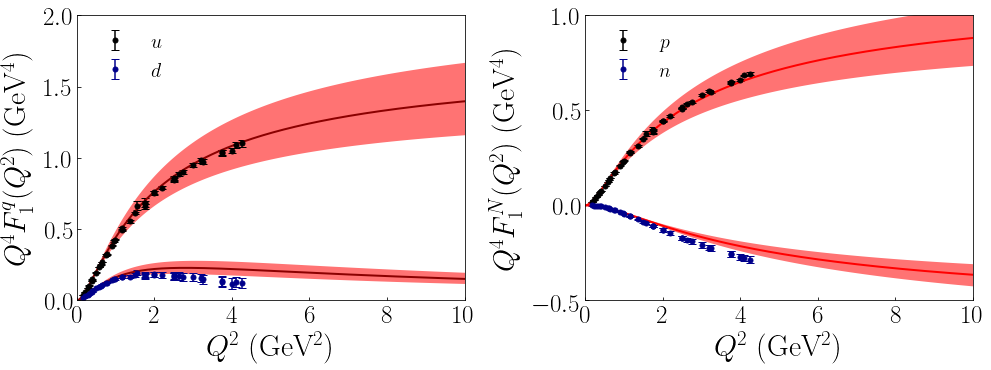

In [96]:
nrows, ncols = 1, 2

Q2 = np.linspace(0, 40, 5000)

Par.reset()
q4f1u = Q2**2 * F1u(Q2)
q4f1d = Q2**2 * F1d(Q2)
q4f1p = Q2**2 * F1p(Q2)
q4f1n = Q2**2 * F1n(Q2)
Par.kappa = Parameters.kappa * 1.05
q4f1uA = Q2**2 * F1u(Q2)
q4f1dA = Q2**2 * F1d(Q2)
q4f1pA = Q2**2 * F1p(Q2)
q4f1nA = Q2**2 * F1n(Q2)
Par.kappa = Parameters.kappa * 0.95
q4f1uB = Q2**2 * F1u(Q2)
q4f1dB = Q2**2 * F1d(Q2)
q4f1pB = Q2**2 * F1p(Q2)
q4f1nB = Q2**2 * F1n(Q2)

fig = plt.figure(figsize=(ncols*7, nrows*7*0.75))

ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**2 * data['F1F2ud']['F1u'],\
            yerr=data['F1F2ud']['Q2']**2 * data['F1F2ud']['dF1u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**2 * data['F1F2ud']['F1d'],\
            yerr=data['F1F2ud']['Q2']**2 * data['F1F2ud']['dF1d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, q4f1uA, q4f1uB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q4f1u, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, q4f1dA, q4f1dB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q4f1d, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(0, 10)
ax.set_ylim(0, 2)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^4F_1^q(Q^2)~\rm (GeV^4)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**2 * data['F1F2pn']['F1p'],\
            yerr=data['F1F2pn']['Q2']**2 * data['F1F2pn']['dF1p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**2 * data['F1F2pn']['F1n'],\
            yerr=data['F1F2pn']['Q2']**2 * data['F1F2pn']['dF1n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$n$')
ax.fill_between(Q2, q4f1pA, q4f1pB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q4f1p, linestyle = '-', linewidth=2, color = 'red')
ax.fill_between(Q2, q4f1nA, q4f1nB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q4f1n, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(0, 10)
ax.set_ylim(-0.5, 1)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^4F_1^N(Q^2)~\rm (GeV^4)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')


fig.tight_layout()
fig.savefig('plots/F1fit.pdf')

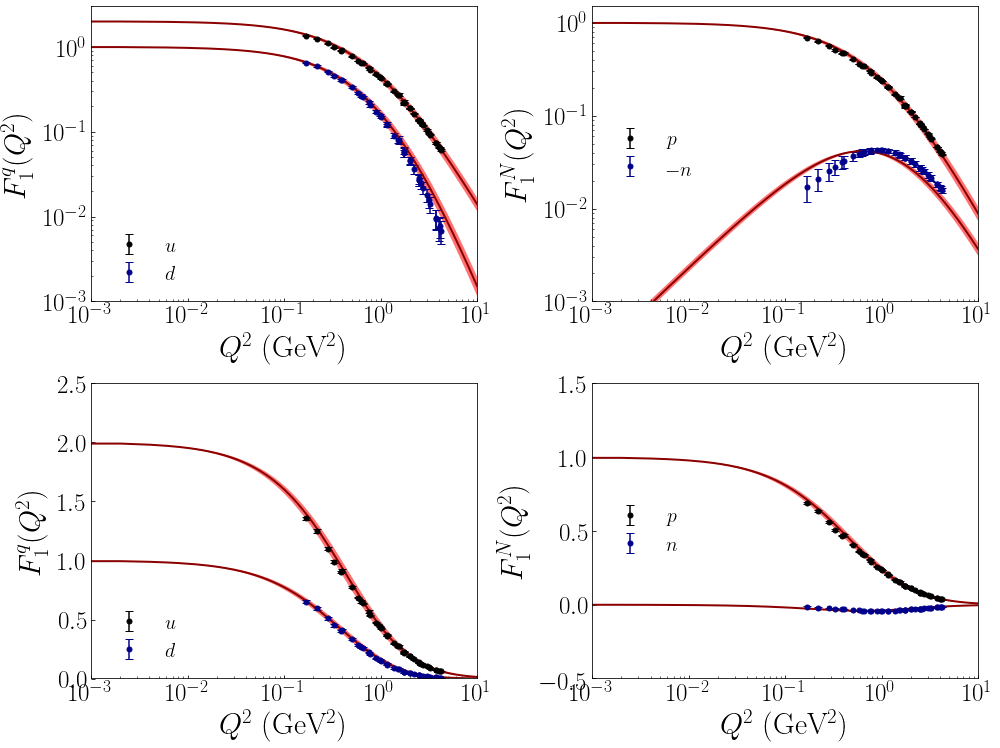

In [97]:
nrows, ncols = 2, 2

Q2 = np.linspace(0, 40, 20000)

Par.reset()
f1u = F1u(Q2)
f1d = F1d(Q2)
f1p = F1p(Q2)
f1n = F1n(Q2)
Par.kappa = Parameters.kappa * 1.05
f1uA = F1u(Q2)
f1dA = F1d(Q2)
f1pA = F1p(Q2)
f1nA = F1n(Q2)
Par.kappa = Parameters.kappa * 0.95
f1uB = F1u(Q2)
f1dB = F1d(Q2)
f1pB = F1p(Q2)
f1nB = F1n(Q2)

fig = plt.figure(figsize=(ncols*7, nrows*7*0.75))

ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F1u'], yerr=data['F1F2ud']['dF1u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F1d'], yerr=data['F1F2ud']['dF1d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, f1uA, f1uB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f1u, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, f1dA, f1dB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f1d, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_1^q(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'lower left')

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F1p'], yerr=data['F1F2pn']['dF1p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], -data['F1F2pn']['F1n'], yerr=data['F1F2pn']['dF1n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$-n$')
ax.fill_between(Q2, f1pA, f1pB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f1p, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, -f1nA, -f1nB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, -f1n, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_1^N(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'center left')

ax = fig.add_subplot(nrows, ncols, 3)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F1u'], yerr=data['F1F2ud']['dF1u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F1d'], yerr=data['F1F2ud']['dF1d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, f1uA, f1uB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f1u, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, f1dA, f1dB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f1d, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 2.5)
ax.set_xscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_1^q(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'lower left')

ax = fig.add_subplot(nrows, ncols, 4)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F1p'], yerr=data['F1F2pn']['dF1p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F1n'], yerr=data['F1F2pn']['dF1n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$n$')
ax.fill_between(Q2, f1pA, f1pB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f1p, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, f1nA, f1nB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f1n, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(-0.5, 1.5)
ax.set_xscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_1^N(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'center left')


fig.tight_layout()
fig.savefig('plots/F1fitlog.pdf')

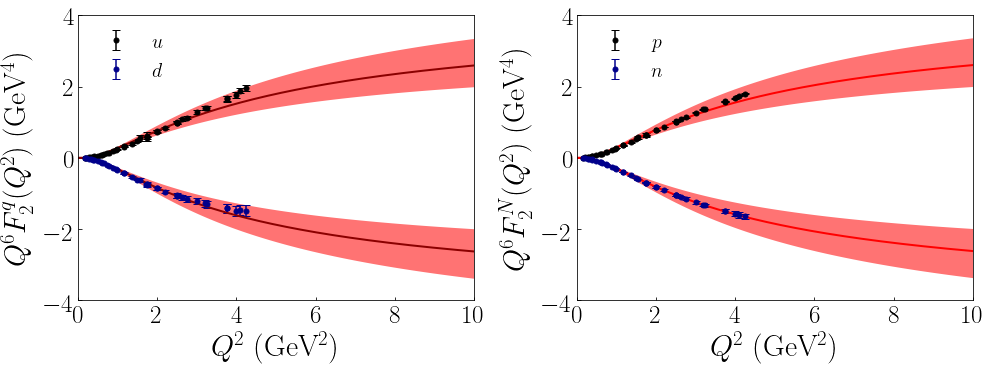

In [101]:
nrows, ncols = 1, 2

Q2 = np.linspace(0, 40, 5000)

Par.reset()
q6f2u = Q2**3 * F2u(Q2)
q6f2d = Q2**3 * F2d(Q2)
q6f2p = Q2**3 * F2p(Q2)
q6f2n = Q2**3 * F2n(Q2)
Par.kappa = Parameters.kappa * 1.05
q6f2uA = Q2**3 * F2u(Q2)
q6f2dA = Q2**3 * F2d(Q2)
q6f2pA = Q2**3 * F2p(Q2)
q6f2nA = Q2**3 * F2n(Q2)
Par.kappa = Parameters.kappa * 0.95
q6f2uB = Q2**3 * F2u(Q2)
q6f2dB = Q2**3 * F2d(Q2)
q6f2pB = Q2**3 * F2p(Q2)
q6f2nB = Q2**3 * F2n(Q2)

fig = plt.figure(figsize=(ncols*7, nrows*7*0.75))

ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**3 * data['F1F2ud']['F2u'],\
            yerr=data['F1F2ud']['Q2']**3 * data['F1F2ud']['dF2u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['Q2']**3 * data['F1F2ud']['F2d'],\
            yerr=data['F1F2ud']['Q2']**3 * data['F1F2ud']['dF2d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, q6f2uA, q6f2uB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q6f2u, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, q6f2dA, q6f2dB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q6f2d, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(0, 10)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^6F_2^q(Q^2)~\rm (GeV^4)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**3 * data['F1F2pn']['F2p'],\
            yerr=data['F1F2pn']['Q2']**3 * data['F1F2pn']['dF2p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['Q2']**3 * data['F1F2pn']['F2n'],\
            yerr=data['F1F2pn']['Q2']**3 * data['F1F2pn']['dF2n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$n$')
ax.fill_between(Q2, q6f2pA, q6f2pB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q6f2p, linestyle = '-', linewidth=2, color = 'red')
ax.fill_between(Q2, q6f2nA, q6f2nB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, q6f2n, linestyle = '-', linewidth=2, color = 'red')
ax.set_xlim(0, 10)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$Q^6F_2^N(Q^2)~\rm (GeV^4)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'upper left')


fig.tight_layout()
fig.savefig('plots/F2fit.pdf')

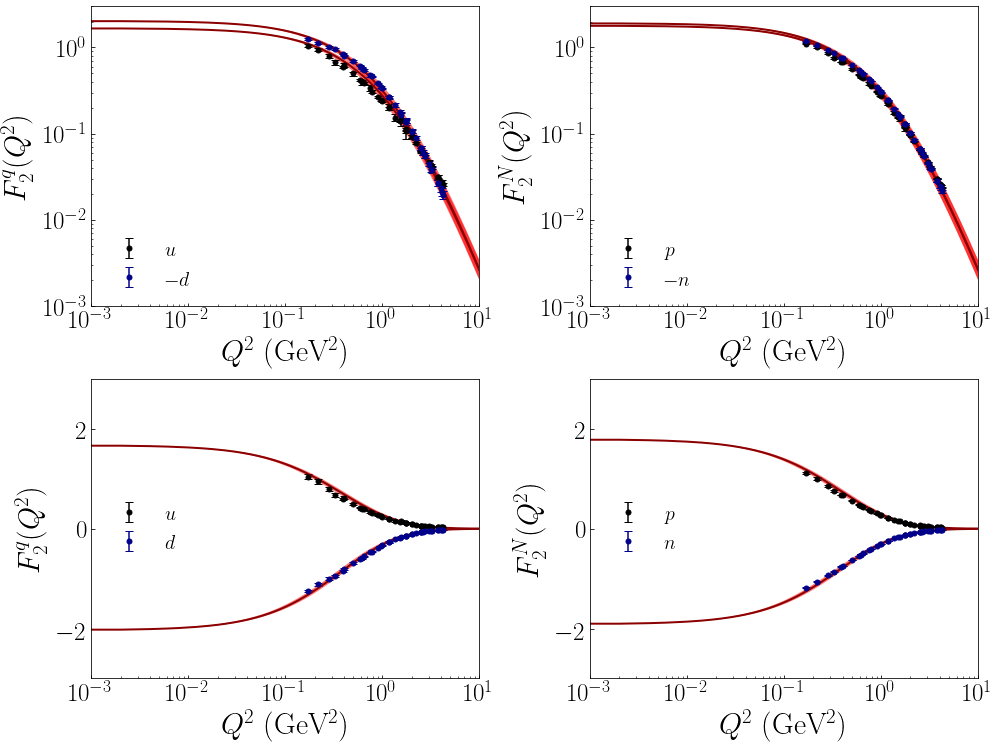

In [100]:
nrows, ncols = 2, 2

Q2 = np.linspace(0, 40, 20000)

Par.reset()
f2u = F2u(Q2)
f2d = F2d(Q2)
f2p = F2p(Q2)
f2n = F2n(Q2)
Par.kappa = Parameters.kappa * 1.05
f2uA = F2u(Q2)
f2dA = F2d(Q2)
f2pA = F2p(Q2)
f2nA = F2n(Q2)
Par.kappa = Parameters.kappa * 0.95
f2uB = F2u(Q2)
f2dB = F2d(Q2)
f2pB = F2p(Q2)
f2nB = F2n(Q2)

fig = plt.figure(figsize=(ncols*7, nrows*7*0.75))

ax = fig.add_subplot(nrows, ncols, 1)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F2u'], yerr=data['F1F2ud']['dF2u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], -data['F1F2ud']['F2d'], yerr=data['F1F2ud']['dF2d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$-d$')
ax.fill_between(Q2, f2uA, f2uB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f2u, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, -f2dA, -f2dB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, -f2d, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_2^q(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'lower left')

ax = fig.add_subplot(nrows, ncols, 2)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F2p'], yerr=data['F1F2pn']['dF2p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], -data['F1F2pn']['F2n'], yerr=data['F1F2pn']['dF2n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$-n$')
ax.fill_between(Q2, f2pA, f2pB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f2p, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, -f2nA, -f2nB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, -f2n, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(1e-3, 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_2^N(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'lower left')

ax = fig.add_subplot(nrows, ncols, 3)
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F2u'], yerr=data['F1F2ud']['dF2u'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$u$')
ax.errorbar(data['F1F2ud']['Q2'], data['F1F2ud']['F2d'], yerr=data['F1F2ud']['dF2d'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$d$')
ax.fill_between(Q2, f2uA, f2uB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f2u, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, f2dA, f2dB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f2d, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(-3, 3)
ax.set_xscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_2^q(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'center left')

ax = fig.add_subplot(nrows, ncols, 4)
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F2p'], yerr=data['F1F2pn']['dF2p'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'black', label=r'$p$')
ax.errorbar(data['F1F2pn']['Q2'], data['F1F2pn']['F2n'], yerr=data['F1F2pn']['dF2n'],\
            linestyle = '', marker = 'o', markersize = 5, capsize = 4, color = 'darkblue', label=r'$n$')
ax.fill_between(Q2, f2pA, f2pB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f2p, linestyle = '-', linewidth=2, color = 'darkred')
ax.fill_between(Q2, f2nA, f2nB, color = 'red', alpha = 0.55, linewidth = 0)
ax.plot(Q2, f2n, linestyle = '-', linewidth=2, color = 'darkred')
ax.set_xlim(1e-3, 10)
ax.set_ylim(-3, 3)
ax.set_xscale('log')
ax.set_xlabel(r'$Q^2~\rm (GeV^2)$', size=30)
ax.set_ylabel(r'$F_2^N(Q^2)$', size = 30)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize = 25)
ax.legend(frameon = False, fontsize = 20, loc = 'center left')

fig.tight_layout()
fig.savefig('plots/F2fitlog.pdf')